In [110]:
# Startup steps
import pandas as pd, numpy as np, statsmodels.api as sm
import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import time, requests
import copy
from scipy.stats import pearsonr, ttest_rel
from patsy import dmatrices
import seaborn as sns
sns.set()
%matplotlib inline
import pickle

# Questions

1. Which price is better?  Open price, close price, high price or low price?
2. Which variable is better? Price or Volume?
3. When should I use log in linear model?
4. Absolute value or diffencial?
5. How to solve multicollinearity problems?
6. What if the data has delay? E.g. effective after 2 days
7. Can I explain NFT price with internal variables within NFT markets?
8. Can I take the average sale price to do regression, or average price of all assets?

# Data overview

### NFT market

[x] primary sale (PrimarySale),  
[x] secondary sale,  
[x] primary sale USD,  
[x] secondary sale USD,  
[x] and control for the changes in the number of unique wallets (ΔNumWallets),   
[x] the number of buyers (ΔNumBuyers),   
[x] the number of sellers (ΔNumSellers),   
[x] the number of sales (ΔNumSales),   
[x] the sales volume in USD (ΔSalesUSD),   

### External enviroment

<!--
[ ] ETHUSD exchange rate (ΔETHUSD),   
[ ] the ETH trading volume (ΔETHVol)    
-->
[x] ETH price in USD   
[x] BTC price in USD  
[x] Google Search Index of keywords: "metaverse", "NFT", "BAYC", "cryptopunks"


### Others

[x] dummy vairbales of each month

# Load data

### Basic NFT Indice

In [4]:
def color_corr_level(val):
    val = abs(val)
    if val>0.8:
        color = 'red'
    elif val>0.3:
        color = 'orange'
    else:
        color = 'black'
    return 'color:%s'%color

In [5]:
def load_month(date):
    return date.month

In [6]:
df_NFT = pd.read_csv('data/nonfungible/Data_NFT_all_with_delta.csv')
df_NFT["DateTime"] = pd.to_datetime(df_NFT["DateTime"])

In [7]:
df_NFT_recent_year = df_NFT[-377:-12].reset_index().drop(labels=['index'], axis=1)

In [8]:
df_NFT_recent_year = df_NFT_recent_year.rename(columns={"Average USD":"Average NFT in USD", "ΔAverage USD":"ΔAverage NFT in USD"})

In [9]:
df_NFT_recent_year['Sales USD']/df_NFT_recent_year['Number of sales']

0      652.282523
1      650.981050
2      763.237283
3      833.196627
4      878.274777
          ...    
360    372.299881
361    465.658718
362    707.699654
363    441.048716
364    504.884740
Length: 365, dtype: float64

In [10]:
df_NFT_recent_year['Average NFT in USD']

0      652.28
1      650.98
2      763.24
3      833.20
4      878.27
        ...  
360    372.12
361    465.35
362    706.45
363    440.43
364    504.38
Name: Average NFT in USD, Length: 365, dtype: float64

In [11]:
df_NFT_recent_year.corr().style.applymap(color_corr_level)

,Average NFT in USD,Active market wallets,Number of sales,Sales USD,Primary Sales,Secondary sales,Primary sales USD,Secondary sales USD,Unique buyers,Unique sellers,ΔAverage NFT in USD,ΔActive market wallets,ΔNumber of sales,ΔSales USD,ΔPrimary Sales,ΔSecondary sales,ΔPrimary sales USD,ΔSecondary sales USD,ΔUnique buyers,ΔUnique sellers
Average NFT in USD,1,-0.0758781,-0.215075,0.576706,-0.247472,-0.170983,0.418804,0.599188,-0.0953995,-0.0882193,-0.348353,-0.043488,0.0326016,-0.281136,0.0154182,0.0436416,-0.286833,-0.24148,-0.0725128,0.0249701
Active market wallets,-0.0758781,1,0.929564,0.623948,0.789697,0.975575,0.46194,0.64379,0.994759,0.99026,-0.0185977,-0.112951,-0.107796,-0.0601793,-0.0854946,-0.0952956,-0.0609803,-0.052106,-0.112098,-0.0963481
Number of sales,-0.215075,0.929564,1,0.543655,0.950024,0.964558,0.454317,0.534633,0.951019,0.903759,-0.0133987,-0.103701,-0.155867,-0.0643928,-0.15842,-0.0883871,-0.0616943,-0.0592849,-0.11655,-0.0771945
Sales USD,0.576706,0.623948,0.543655,1,0.498351,0.539715,0.86704,0.967476,0.631317,0.579144,-0.372313,-0.171443,-0.118282,-0.421225,-0.135013,-0.0460694,-0.44213,-0.349529,-0.215202,-0.0568132
Primary Sales,-0.247472,0.789697,0.950024,0.498351,1,0.833979,0.474543,0.46059,0.834764,0.738788,-0.0320381,-0.0975211,-0.181137,-0.0926688,-0.229413,-0.0383866,-0.0962385,-0.0779183,-0.131827,-0.0405252
Secondary sales,-0.170983,0.975575,0.964558,0.539715,0.833979,1,0.401927,0.555686,0.975405,0.972993,0.00339732,-0.100868,-0.122399,-0.0354899,-0.0861047,-0.123784,-0.0277027,-0.0389294,-0.0945836,-0.102193
Primary sales USD,0.418804,0.46194,0.454317,0.86704,0.474543,0.401927,1,0.712805,0.491612,0.394609,-0.441611,-0.177628,-0.107029,-0.514699,-0.15972,0.0116263,-0.62066,-0.347254,-0.244875,-0.0111671
Secondary sales USD,0.599188,0.64379,0.534633,0.967476,0.46059,0.555686,0.712805,1,0.639098,0.614905,-0.299886,-0.151152,-0.112162,-0.33163,-0.108963,-0.0707532,-0.307261,-0.31572,-0.17861,-0.0743047
Unique buyers,-0.0953995,0.994759,0.951019,0.631317,0.834764,0.975405,0.491612,0.639098,1,0.97402,-0.0280825,-0.121355,-0.12629,-0.0771394,-0.115799,-0.0894455,-0.0803729,-0.0646,-0.133677,-0.0881676
Unique sellers,-0.0882193,0.99026,0.903759,0.579144,0.738788,0.972993,0.394609,0.614905,0.97402,1,-0.00193724,-0.110522,-0.0984203,-0.0363543,-0.0554431,-0.119116,-0.0306591,-0.0376119,-0.0933977,-0.121157


### External indice

In [12]:
df_BTC = pd.read_csv('data/BTC-USD-complete.csv')
df_BTC=df_BTC.rename(columns={"Open":"Open_BTC"})
df_ETH = pd.read_csv('data/ETH-USD-complete.csv')
df_ETH=df_ETH.rename(columns={"Open":"Open_ETH"})
df_NASDAQ = pd.read_csv('data/NASDAQ-complete.csv')
df_NASDAQ=df_NASDAQ.rename(columns={"Open":"Open_NASDAQ"})
df_USD = pd.read_csv('data/USD_index-complete.csv')
df_USD=df_USD.rename(columns={"Open":"Open_USD"})
# df_ETH.rename(columns={"Open":"open_ETH", "High":"high_ETH", "Low":"low_ETH", "Close":"close_ETH", "Adj Close":"adj_close_ETH", "Volume":"volume_ETH"})

In [13]:
# pd.concat([df_extern, df_USD[['Date','Open_USD']]], sort=False, axis=1)
df_extern = df_ETH[['Date','Open_ETH']].merge(
    df_BTC[['Date','Open_BTC']]).merge(
    df_NASDAQ[['Date','Open_NASDAQ']],how='left').merge(
    df_USD[['Date', 'Open_USD']],how='left')

In [14]:
df_ETH

,Date,Open_ETH,High,Low,Close,Adj Close,Volume
0,2021-10-01,3001.129395,3329.853516,2978.654297,3307.516113,3307.516113,22307625573
1,2021-10-02,3308.870361,3464.837402,3260.027588,3391.694336,3391.694336,19202671704
2,2021-10-03,3390.767578,3484.605713,3348.120117,3418.358643,3418.358643,15516566862
3,2021-10-04,3418.776367,3434.775391,3283.448730,3380.089111,3380.089111,17747154101
4,2021-10-05,3381.784424,3541.451660,3365.817627,3518.518555,3518.518555,16632591670
...,...,...,...,...,...,...,...
360,2022-09-26,1294.386108,1335.526367,1282.049316,1335.320190,1335.320190,16034549271
361,2022-09-27,1335.337036,1396.891479,1308.991455,1330.127686,1330.127686,17870598937
362,2022-09-28,1329.541382,1351.964478,1267.869263,1337.410889,1337.410889,18994979566
363,2022-09-29,1337.554443,1348.107666,1293.193359,1335.652344,1335.652344,13796915736


In [15]:
df_extern.corr()

,Open_ETH,Open_BTC,Open_NASDAQ,Open_USD
Open_ETH,1.000000,0.970638,0.949600,-0.859742
Open_BTC,0.970638,1.000000,0.910289,-0.899479
Open_NASDAQ,0.949600,0.910289,1.000000,-0.861171
Open_USD,-0.859742,-0.899479,-0.861171,1.000000


### Google Trends - Search Volume Index(SVI)

In [16]:
df_SVI = pd.read_csv('data/SVI/SVI_all.csv')

In [17]:
df_SVI.corr()

,BAYC,bored ape yacht club,cryptopunks,metaverse,NFT
BAYC,1.000000,0.416803,0.115036,0.228598,0.270017
bored ape yacht club,0.416803,1.000000,0.194442,0.330041,0.192143
cryptopunks,0.115036,0.194442,1.000000,0.031367,0.090928
metaverse,0.228598,0.330041,0.031367,1.000000,0.269459
NFT,0.270017,0.192143,0.090928,0.269459,1.000000


   ### BAYC and Cryptopunk

In [18]:
def str_to_float(s):
    return float(s)

In [19]:
def null_str_to_nan(s):
    if s=='':
        return np.nan
    else:
        return s

In [20]:
prices_BAYC = pickle.load(open('data/BAYC_collection_price_full_month.pickle','rb'))
prices_cryptopunks = pickle.load(open('data/cryptopunks_collection_price_full_month.pickle','rb'))

In [21]:
df_price_BAYC = pd.DataFrame(prices_BAYC).astype({'avg':'float'})
df_price_cryptopunks = pd.DataFrame(prices_cryptopunks).applymap(null_str_to_nan)

In [22]:
df_price_cryptopunks[230:235]

,timestamp,min,max,avg
230,2022-05-19T00:00:00Z,51.94,149.99,74.6433333333333333
231,2022-05-20T00:00:00Z,50.8,54.54,52.2833333333333333
232,2022-05-21T00:00:00Z,NaN,NaN,NaN
233,2022-05-22T00:00:00Z,54.2,78,66.1
234,2022-05-23T00:00:00Z,47.9,190,77.8285714285714286


In [23]:
df_price_BAYC['avg'][0]

48.45576923076923

### Select those needed data

In [24]:
df_NFT_recent_year.columns

Index(['DateTime', 'Average NFT in USD', 'Active market wallets',
       'Number of sales', 'Sales USD', 'Primary Sales', 'Secondary sales',
       'Primary sales USD', 'Secondary sales USD', 'Unique buyers',
       'Unique sellers', 'ΔAverage NFT in USD', 'ΔActive market wallets',
       'ΔNumber of sales', 'ΔSales USD', 'ΔPrimary Sales', 'ΔSecondary sales',
       'ΔPrimary sales USD', 'ΔSecondary sales USD', 'ΔUnique buyers',
       'ΔUnique sellers'],
      dtype='object')

In [25]:
df_select = pd.concat([df_NFT_recent_year[['DateTime','Average NFT in USD','Active market wallets']], df_extern.add_prefix('extern '), df_SVI[['NFT','metaverse']].add_prefix('SVI ')], axis=1)

In [26]:
df_select_with_delta = pd.concat([df_select, df_NFT_recent_year[['ΔActive market wallets','ΔNumber of sales','ΔSales USD']] ], axis=1)

In [27]:
df_select_with_delta

,DateTime,Average NFT in USD,Active market wallets,extern Date,extern Open_ETH,extern Open_BTC,extern Open_NASDAQ,extern Open_USD,SVI NFT,SVI metaverse,ΔActive market wallets,ΔNumber of sales,ΔSales USD
0,2021-10-01,652.28,76795.0,2021-10-01,3001.129395,43816.742188,14494.929688,94.309998,1243,303,-1875.0,-11520.0,-7732405.90
1,2021-10-02,650.98,74920.0,2021-10-02,3308.870361,48137.468750,NaN,NaN,1215,210,1694.0,29.0,18834931.40
2,2021-10-03,763.24,76614.0,2021-10-03,3390.767578,47680.027344,NaN,NaN,1253,423,13978.0,26701.0,33973558.60
3,2021-10-04,833.20,90592.0,2021-10-04,3418.776367,48208.906250,14493.120117,94.070000,1340,495,-5033.0,-38961.0,-25458967.70
4,2021-10-05,878.27,85559.0,2021-10-05,3381.784424,49174.960938,14312.860352,93.830002,1441,374,-6479.0,116.0,-15096542.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022-09-26,372.12,16446.0,2022-09-26,1294.386108,18803.900391,10833.379883,113.019997,1578,1334,2378.0,260.0,2623928.33
361,2022-09-27,465.35,18824.0,2022-09-27,1335.337036,19221.839844,10955.290039,114.019997,1716,1307,-906.0,1220.0,7415199.67
362,2022-09-28,706.45,17918.0,2022-09-28,1329.541382,19104.621094,10817.519531,114.190002,1754,1275,-774.0,5277.0,-5215874.32
363,2022-09-29,440.43,17144.0,2022-09-29,1337.554443,19427.779297,10894.440430,113.010002,1734,1549,-593.0,-4702.0,-231248.07


In [28]:
df_select_with_delta.corr().style.applymap(color_corr_level)

,Average NFT in USD,Active market wallets,extern Open_ETH,extern Open_BTC,extern Open_NASDAQ,extern Open_USD,SVI NFT,SVI metaverse,ΔActive market wallets,ΔNumber of sales,ΔSales USD
Average NFT in USD,1,-0.0758781,0.037299,0.0319385,-0.0507861,-0.0924814,0.381812,0.287036,-0.043488,0.0326016,-0.281136
Active market wallets,-0.0758781,1,0.821839,0.826094,0.844409,-0.860896,-0.20763,-0.0102185,-0.112951,-0.107796,-0.0601793
extern Open_ETH,0.037299,0.821839,1,0.970638,0.9496,-0.859742,-0.191343,0.0306952,0.0137943,-0.0122462,0.0041817
extern Open_BTC,0.0319385,0.826094,0.970638,1,0.910289,-0.899479,-0.169383,-0.0742816,0.013004,-0.0101449,0.00409803
extern Open_NASDAQ,-0.0507861,0.844409,0.9496,0.910289,1,-0.861171,-0.283626,-0.0532355,0.0383737,0.00787907,-0.0037822
extern Open_USD,-0.0924814,-0.860896,-0.859742,-0.899479,-0.861171,1,0.165663,0.102007,-0.0188892,0.0149109,0.00380405
SVI NFT,0.381812,-0.20763,-0.191343,-0.169383,-0.283626,0.165663,1,0.269459,0.0226426,0.0376611,-0.00923338
SVI metaverse,0.287036,-0.0102185,0.0306952,-0.0742816,-0.0532355,0.102007,0.269459,1,-0.0467833,-0.0116794,0.00316434
ΔActive market wallets,-0.043488,-0.112951,0.0137943,0.013004,0.0383737,-0.0188892,0.0226426,-0.0467833,1,0.792502,0.471777
ΔNumber of sales,0.0326016,-0.107796,-0.0122462,-0.0101449,0.00787907,0.0149109,0.0376611,-0.0116794,0.792502,1,0.366564


# Hedonic Regression

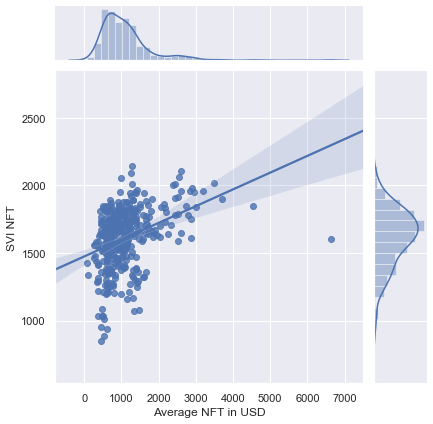

In [25]:
g = sns.jointplot("Average NFT in USD", "SVI NFT", data=df_select, kind="reg")

In [26]:
df_reg = df_select_with_delta.rename(columns={"Average NFT in USD":"Average_NFT_in_USD",
                                   "extern Open_USD":"extern_Open_USD",
                                   "extern Open_NASDQA":"extern_Open_NASDAQ",
                                   "extern Open_BTC":"extern_Open_BTC",
                                   "extern Open_ETH":"extern_Open_ETH",
                                   "SVI BAYC":"SVI_BAYC",
                                   "SVI cryptopunks":"SVI_cryptopunks",
                                   "SVI NFT":"SVI_NFT",
                                   "SVI metaverse":"SVI_metaverse",
                                   "Active market wallets":"Active_market_wallets",
                                   "ΔSales USD":"ΔSales_USD",
                                   "ΔActive market wallets":"ΔActive_market_wallets"
                                    })

In [27]:
from patsy import dmatrices
y, X = dmatrices("np.log(Average_NFT_in_USD) ~ SVI_NFT + SVI_metaverse + extern_Open_USD + extern_Open_ETH + extern_Open_BTC + Active_market_wallets + ΔSales_USD + ΔActive_market_wallets", 
                 data=df_reg, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     np.log(Average_NFT_in_USD)   R-squared:                       0.504
Model:                                    OLS   Adj. R-squared:                  0.488
Method:                         Least Squares   F-statistic:                     31.13
Date:                        Sun, 23 Oct 2022   Prob (F-statistic):           2.06e-33
Time:                                11:50:03   Log-Likelihood:                -94.079
No. Observations:                         254   AIC:                             206.2
Df Residuals:                             245   BIC:                             238.0
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

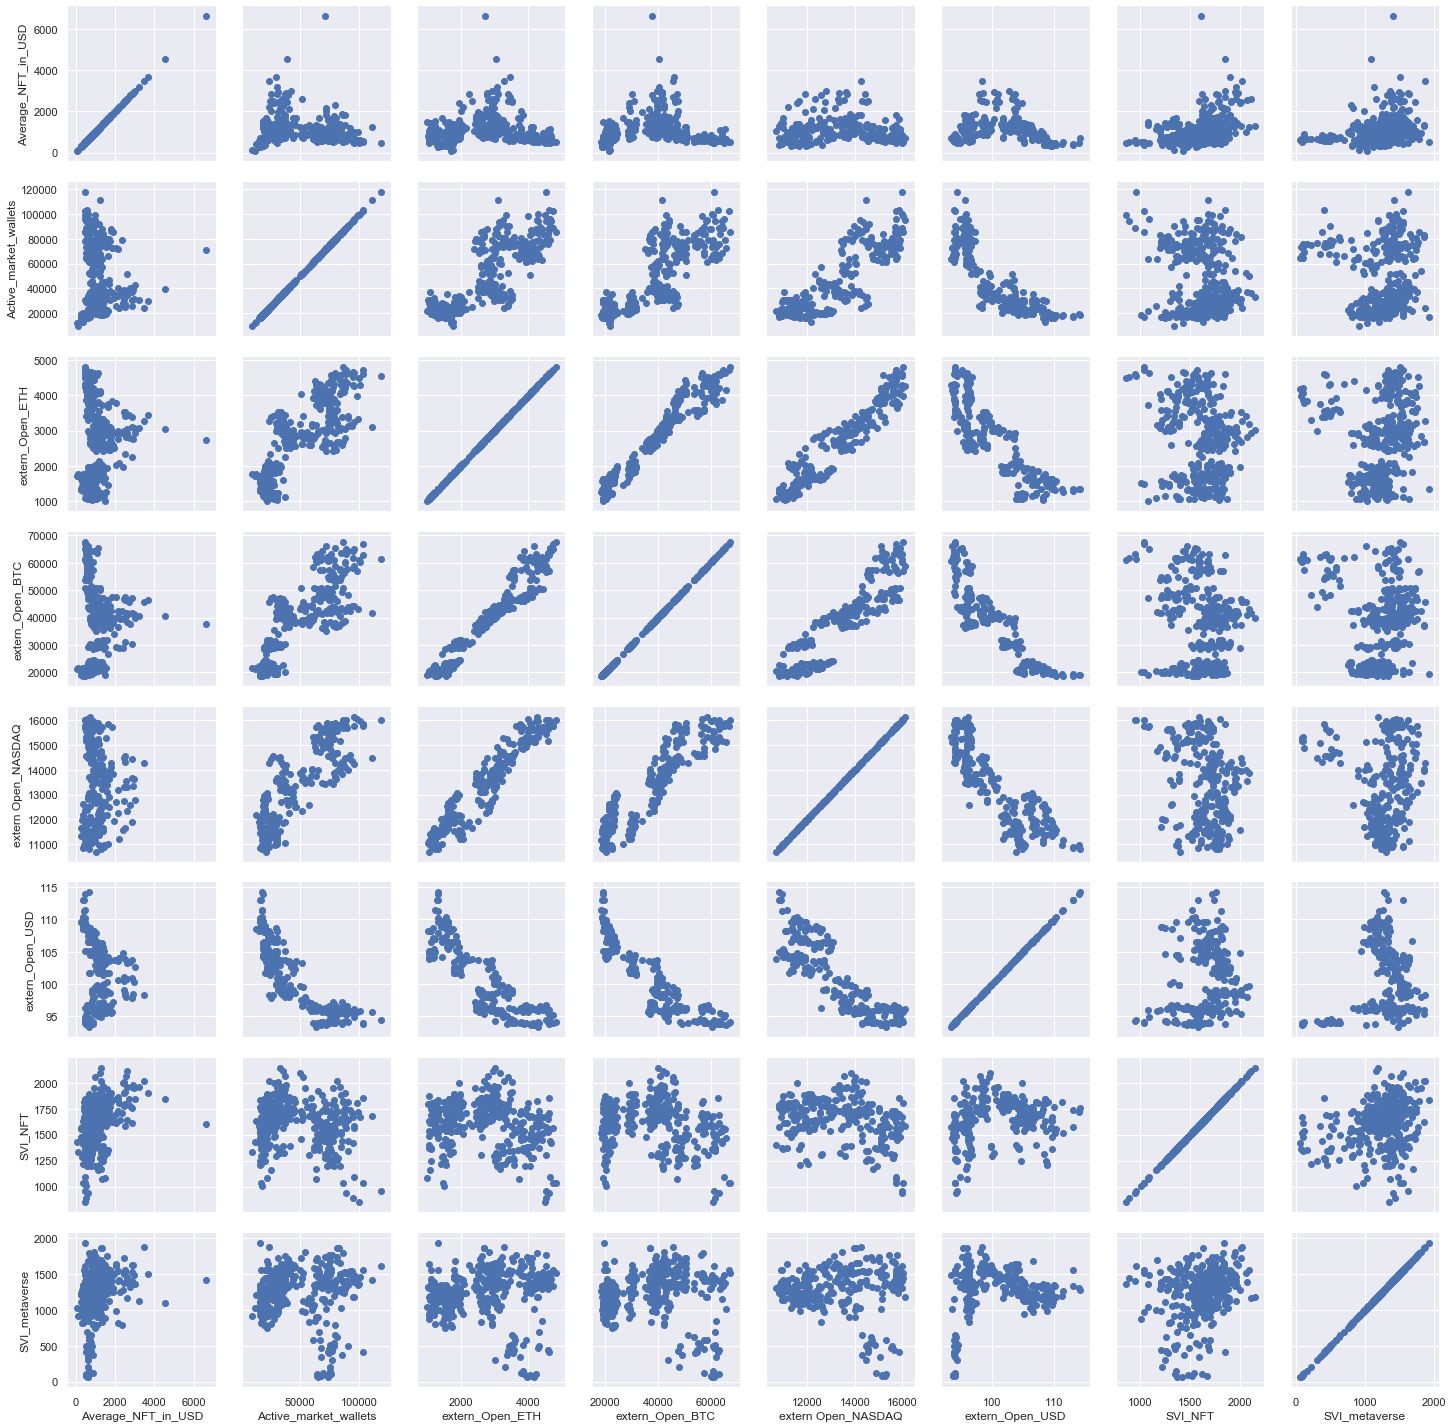

In [35]:
g = sns.PairGrid(df_reg)
g.map(plt.scatter)

In [36]:
g.savefig('pairgrid.png', dpi=100)

## Price Model

model:  
$$
\log P_t = \log P + \sum_n^N \gamma_n Network_{n,t} + \sum_t^T \delta_tT_t,\qquad t={1,2,3...12}
$$
Network factors are the impact of extern enviroment including USD Index, price of ETH, price of BTC, search index of keywords "metaverse", "NFT", and corresponding collection name.

### The Price of BAYC

In [34]:
df_select_BAYC = pd.concat([df_select, df_price_BAYC[['avg']].astype("float").add_prefix("BAYC Price "), df_SVI[['BAYC','bored ape yacht club']].add_prefix("SVI ") ], axis=1)

In [35]:
df_select_BAYC

,DateTime,Average NFT in USD,Active market wallets,extern Date,extern Open_ETH,extern Open_BTC,extern Open_NASDAQ,extern Open_USD,SVI NFT,SVI metaverse,BAYC Price avg,SVI BAYC,SVI bored ape yacht club
0,2021-10-01,652.28,76795.0,2021-10-01,3001.129395,43816.742188,14494.929688,94.309998,1243,303,48.455769,300,133
1,2021-10-02,650.98,74920.0,2021-10-02,3308.870361,48137.468750,NaN,NaN,1215,210,44.312900,335,134
2,2021-10-03,763.24,76614.0,2021-10-03,3390.767578,47680.027344,NaN,NaN,1253,423,45.728261,155,227
3,2021-10-04,833.20,90592.0,2021-10-04,3418.776367,48208.906250,14493.120117,94.070000,1340,495,55.412926,179,156
4,2021-10-05,878.27,85559.0,2021-10-05,3381.784424,49174.960938,14312.860352,93.830002,1441,374,46.151034,221,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022-09-26,372.12,16446.0,2022-09-26,1294.386108,18803.900391,10833.379883,113.019997,1578,1334,82.912592,89,314
361,2022-09-27,465.35,18824.0,2022-09-27,1335.337036,19221.839844,10955.290039,114.019997,1716,1307,98.291753,209,187
362,2022-09-28,706.45,17918.0,2022-09-28,1329.541382,19104.621094,10817.519531,114.190002,1754,1275,91.715395,313,222
363,2022-09-29,440.43,17144.0,2022-09-29,1337.554443,19427.779297,10894.440430,113.010002,1734,1549,64.370529,94,228


In [36]:
df_select_BAYC.corr().style.applymap(color_corr_level)

,Average NFT in USD,Active market wallets,extern Open_ETH,extern Open_BTC,extern Open_NASDAQ,extern Open_USD,SVI NFT,SVI metaverse,BAYC Price avg,SVI BAYC,SVI bored ape yacht club
Average NFT in USD,1,-0.0758781,0.037299,0.0319385,-0.0507861,-0.0924814,0.381812,0.287036,0.526829,0.391387,0.272753
Active market wallets,-0.0758781,1,0.821839,0.826094,0.844409,-0.860896,-0.20763,-0.0102185,-0.436728,-0.119642,0.223373
extern Open_ETH,0.037299,0.821839,1,0.970638,0.9496,-0.859742,-0.191343,0.0306952,-0.479193,-0.083835,0.171772
extern Open_BTC,0.0319385,0.826094,0.970638,1,0.910289,-0.899479,-0.169383,-0.0742816,-0.484506,-0.0945062,0.122213
extern Open_NASDAQ,-0.0507861,0.844409,0.9496,0.910289,1,-0.861171,-0.283626,-0.0532355,-0.497359,-0.160558,0.269776
extern Open_USD,-0.0924814,-0.860896,-0.859742,-0.899479,-0.861171,1,0.165663,0.102007,0.360354,0.0308157,-0.291718
SVI NFT,0.381812,-0.20763,-0.191343,-0.169383,-0.283626,0.165663,1,0.269459,0.467401,0.270017,0.192143
SVI metaverse,0.287036,-0.0102185,0.0306952,-0.0742816,-0.0532355,0.102007,0.269459,1,0.341547,0.228598,0.330041
BAYC Price avg,0.526829,-0.436728,-0.479193,-0.484506,-0.497359,0.360354,0.467401,0.341547,1,0.376296,0.251526
SVI BAYC,0.391387,-0.119642,-0.083835,-0.0945062,-0.160558,0.0308157,0.270017,0.228598,0.376296,1,0.416803


In [37]:
df_reg_BAYC = df_select_BAYC.rename(columns={"Average NFT in USD":"Average_NFT_in_USD",
                                   "extern Open_USD":"extern_Open_USD",
                                   "extern Open_NASDQA":"extern_Open_NASDAQ",
                                   "extern Open_BTC":"extern_Open_BTC",
                                   "extern Open_ETH":"extern_Open_ETH",
                                   "SVI BAYC":"SVI_BAYC",
                                   "SVI bored ape yacht club":"SVI_bored_ape_yacht_club",
                                   "SVI cryptopunks":"SVI_cryptopunks",
                                   "SVI NFT":"SVI_NFT",
                                   "SVI metaverse":"SVI_metaverse",
                                   "Active market wallets":"Active_market_wallets",
                                   "BAYC Price avg": "BAYC_Price_avg",
                                   "BAYC Price min": "BAYC_Price_min",
                                   "BAYC Price max": "BAYC_Price_max",       
                                    })


In [38]:
df_reg_BAYC['month'] = df_reg_BAYC.DateTime.map(load_month)
dummies = pd.get_dummies(df_reg_BAYC['month'],prefix='month')
df_reg_BAYC_with_dummies = pd.concat([df_reg_BAYC, dummies], axis=1)

In [39]:
df_reg_BAYC_with_dummies

,DateTime,Average_NFT_in_USD,Active_market_wallets,extern Date,extern_Open_ETH,extern_Open_BTC,extern Open_NASDAQ,extern_Open_USD,SVI_NFT,SVI_metaverse,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2021-10-01,652.28,76795.0,2021-10-01,3001.129395,43816.742188,14494.929688,94.309998,1243,303,...,0,0,0,0,0,0,0,1,0,0
1,2021-10-02,650.98,74920.0,2021-10-02,3308.870361,48137.468750,NaN,NaN,1215,210,...,0,0,0,0,0,0,0,1,0,0
2,2021-10-03,763.24,76614.0,2021-10-03,3390.767578,47680.027344,NaN,NaN,1253,423,...,0,0,0,0,0,0,0,1,0,0
3,2021-10-04,833.20,90592.0,2021-10-04,3418.776367,48208.906250,14493.120117,94.070000,1340,495,...,0,0,0,0,0,0,0,1,0,0
4,2021-10-05,878.27,85559.0,2021-10-05,3381.784424,49174.960938,14312.860352,93.830002,1441,374,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022-09-26,372.12,16446.0,2022-09-26,1294.386108,18803.900391,10833.379883,113.019997,1578,1334,...,0,0,0,0,0,0,1,0,0,0
361,2022-09-27,465.35,18824.0,2022-09-27,1335.337036,19221.839844,10955.290039,114.019997,1716,1307,...,0,0,0,0,0,0,1,0,0,0
362,2022-09-28,706.45,17918.0,2022-09-28,1329.541382,19104.621094,10817.519531,114.190002,1754,1275,...,0,0,0,0,0,0,1,0,0,0
363,2022-09-29,440.43,17144.0,2022-09-29,1337.554443,19427.779297,10894.440430,113.010002,1734,1549,...,0,0,0,0,0,0,1,0,0,0


In [40]:
df_reg_BAYC_with_dummies.month_3

0      0
1      0
2      0
3      0
4      0
      ..
360    0
361    0
362    0
363    0
364    0
Name: month_3, Length: 365, dtype: uint8

In [41]:
from patsy import dmatrices
y, X = dmatrices("np.log(BAYC_Price_avg)~np.log(Average_NFT_in_USD) + SVI_NFT + SVI_metaverse + SVI_BAYC + SVI_bored_ape_yacht_club + extern_Open_USD + extern_Open_ETH + extern_Open_BTC + Active_market_wallets \
                 + month_9 + month_10 + month_11 + month_12+ month_1+ month_2+ month_3+ month_4+ month_5+ month_6+ month_7+ month_8", 
                 data=df_reg_BAYC_with_dummies, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(BAYC_Price_avg)   R-squared:                       0.829
Model:                                OLS   Adj. R-squared:                  0.814
Method:                     Least Squares   F-statistic:                     56.28
Date:                    Wed, 26 Oct 2022   Prob (F-statistic):           1.83e-77
Time:                            05:53:22   Log-Likelihood:                 127.21
No. Observations:                     254   AIC:                            -212.4
Df Residuals:                         233   BIC:                            -138.1
Df Model:                              20                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

## The Price of cryptopunks

In [42]:
df_select_cryptopunks = pd.concat([df_select, df_price_cryptopunks[['avg']].astype("float").add_prefix("cryptopunks Price "), df_SVI[['cryptopunks']].add_prefix("SVI ")], axis=1)

In [43]:
df_select_cryptopunks.corr()

,Average NFT in USD,Active market wallets,extern Open_ETH,extern Open_BTC,extern Open_NASDAQ,extern Open_USD,SVI NFT,SVI metaverse,cryptopunks Price avg,SVI cryptopunks
Average NFT in USD,1.000000,-0.075878,0.037299,0.031938,-0.050786,-0.092481,0.381812,0.287036,-0.047975,0.122895
Active market wallets,-0.075878,1.000000,0.821839,0.826094,0.844409,-0.860896,-0.207630,-0.010219,0.206622,0.158589
extern Open_ETH,0.037299,0.821839,1.000000,0.970638,0.949600,-0.859742,-0.191343,0.030695,0.129342,0.162458
extern Open_BTC,0.031938,0.826094,0.970638,1.000000,0.910289,-0.899479,-0.169383,-0.074282,0.159704,0.162665
extern Open_NASDAQ,-0.050786,0.844409,0.949600,0.910289,1.000000,-0.861171,-0.283626,-0.053235,0.158503,0.194884
extern Open_USD,-0.092481,-0.860896,-0.859742,-0.899479,-0.861171,1.000000,0.165663,0.102007,-0.130855,-0.197452
SVI NFT,0.381812,-0.207630,-0.191343,-0.169383,-0.283626,0.165663,1.000000,0.269459,-0.114837,0.090928
SVI metaverse,0.287036,-0.010219,0.030695,-0.074282,-0.053235,0.102007,0.269459,1.000000,-0.211752,0.031367
cryptopunks Price avg,-0.047975,0.206622,0.129342,0.159704,0.158503,-0.130855,-0.114837,-0.211752,1.000000,0.083840
SVI cryptopunks,0.122895,0.158589,0.162458,0.162665,0.194884,-0.197452,0.090928,0.031367,0.083840,1.000000


In [44]:
df_reg_cryptopunks = df_select_cryptopunks.rename(columns={"Average NFT in USD":"Average_NFT_in_USD",
                                   "extern Open_USD":"extern_Open_USD",
                                   "extern Open_NASDQA":"extern_Open_NASDAQ",
                                   "extern Open_BTC":"extern_Open_BTC",
                                   "extern Open_ETH":"extern_Open_ETH",
                                   "SVI BAYC":"SVI_BAYC",
                                   "SVI bored ape yacht club":"SVI_bored_ape_yacht_club",
                                   "SVI cryptopunks":"SVI_cryptopunks",
                                   "SVI NFT":"SVI_NFT",
                                   "SVI metaverse":"SVI_metaverse",
                                   "Active market wallets":"Active_market_wallets",
                                   "cryptopunks Price avg": "cryptopunks_Price_avg",
                                   "cryptopunks Price min": "cryptopunks_Price_min",
                                   "cryptopunks Price max": "cryptopunks_Price_max",       
                                    })


In [45]:
df_reg_cryptopunks['month'] = df_reg_cryptopunks.DateTime.map(load_month)
dummies = pd.get_dummies(df_reg_cryptopunks['month'],prefix='month')
df_reg_cryptopunks_with_dummies = pd.concat([df_reg_cryptopunks, dummies], axis=1)

In [46]:
from patsy import dmatrices
y, X = dmatrices("np.log(cryptopunks_Price_avg)~np.log(Average_NFT_in_USD) + SVI_NFT + SVI_metaverse + SVI_cryptopunks + extern_Open_USD + extern_Open_ETH + extern_Open_BTC + Active_market_wallets \
                 + month_9 + month_10 + month_11 + month_12+ month_1+ month_2+ month_3+ month_4+ month_5+ month_6+ month_7+ month_8", 
                 data=df_reg_cryptopunks_with_dummies, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.log(cryptopunks_Price_avg)   R-squared:                       0.352
Model:                                       OLS   Adj. R-squared:                  0.299
Method:                            Least Squares   F-statistic:                     6.635
Date:                           Wed, 26 Oct 2022   Prob (F-statistic):           9.21e-14
Time:                                   05:53:24   Log-Likelihood:                -18.598
No. Observations:                            252   AIC:                             77.20
Df Residuals:                                232   BIC:                             147.8
Df Model:                                     19                                         
Covariance Type:                       nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----

# Select all data

In [47]:
df_select_all = pd.concat([df_NFT_recent_year, df_extern.drop(labels=['Date'], axis=1).add_prefix('extern '), df_SVI.drop(labels=['date'], axis=1).add_prefix('SVI ')], axis=1)

In [48]:
df_select_all.head()

,DateTime,Average NFT in USD,Active market wallets,Number of sales,Sales USD,Primary Sales,Secondary sales,Primary sales USD,Secondary sales USD,Unique buyers,...,ΔUnique sellers,extern Open_ETH,extern Open_BTC,extern Open_NASDAQ,extern Open_USD,SVI BAYC,SVI bored ape yacht club,SVI cryptopunks,SVI metaverse,SVI NFT
0,2021-10-01,652.28,76795.0,179108.0,116829018.1,94070.0,85038.0,26163901.39,9.066512e+07,58172.0,...,2782.0,3001.129395,43816.742188,14494.929688,94.309998,300,133,324,303,1243
1,2021-10-02,650.98,74920.0,167588.0,109096612.2,80208.0,87380.0,22272713.45,8.682390e+07,53612.0,...,342.0,3308.870361,48137.468750,NaN,NaN,335,134,200,210,1215
2,2021-10-03,763.24,76614.0,167617.0,127931543.6,76925.0,90692.0,23986308.09,1.039452e+08,55060.0,...,12870.0,3390.767578,47680.027344,NaN,NaN,155,227,176,423,1253
3,2021-10-04,833.20,90592.0,194318.0,161905102.2,76886.0,117432.0,30081663.94,1.318234e+08,63148.0,...,-1962.0,3418.776367,48208.906250,14493.120117,94.070000,179,156,278,495,1340
4,2021-10-05,878.27,85559.0,155357.0,136446134.5,53989.0,101368.0,21701218.75,1.147449e+08,57873.0,...,-6497.0,3381.784424,49174.960938,14312.860352,93.830002,221,264,269,374,1441


In [49]:
df_select_all.corr().style.applymap(color_corr_level)

,Average NFT in USD,Active market wallets,Number of sales,Sales USD,Primary Sales,Secondary sales,Primary sales USD,Secondary sales USD,Unique buyers,Unique sellers,ΔAverage NFT in USD,ΔActive market wallets,ΔNumber of sales,ΔSales USD,ΔPrimary Sales,ΔSecondary sales,ΔPrimary sales USD,ΔSecondary sales USD,ΔUnique buyers,ΔUnique sellers,extern Open_ETH,extern Open_BTC,extern Open_NASDAQ,extern Open_USD,SVI BAYC,SVI bored ape yacht club,SVI cryptopunks,SVI metaverse,SVI NFT
Average NFT in USD,1,-0.0758781,-0.215075,0.576706,-0.247472,-0.170983,0.418804,0.599188,-0.0953995,-0.0882193,-0.348353,-0.043488,0.0326016,-0.281136,0.0154182,0.0436416,-0.286833,-0.24148,-0.0725128,0.0249701,0.037299,0.0319385,-0.0507861,-0.0924814,0.391387,0.272753,0.122895,0.287036,0.381812
Active market wallets,-0.0758781,1,0.929564,0.623948,0.789697,0.975575,0.46194,0.64379,0.994759,0.99026,-0.0185977,-0.112951,-0.107796,-0.0601793,-0.0854946,-0.0952956,-0.0609803,-0.052106,-0.112098,-0.0963481,0.821839,0.826094,0.844409,-0.860896,-0.119642,0.223373,0.158589,-0.0102185,-0.20763
Number of sales,-0.215075,0.929564,1,0.543655,0.950024,0.964558,0.454317,0.534633,0.951019,0.903759,-0.0133987,-0.103701,-0.155867,-0.0643928,-0.15842,-0.0883871,-0.0616943,-0.0592849,-0.11655,-0.0771945,0.790354,0.815991,0.802345,-0.771648,-0.191806,0.0897225,0.123765,-0.208758,-0.328584
Sales USD,0.576706,0.623948,0.543655,1,0.498351,0.539715,0.86704,0.967476,0.631317,0.579144,-0.372313,-0.171443,-0.118282,-0.421225,-0.135013,-0.0460694,-0.44213,-0.349529,-0.215202,-0.0568132,0.49076,0.487962,0.617194,-0.689817,0.169019,0.315963,0.147075,0.0785234,0.0294688
Primary Sales,-0.247472,0.789697,0.950024,0.498351,1,0.833979,0.474543,0.46059,0.834764,0.738788,-0.0320381,-0.0975211,-0.181137,-0.0926688,-0.229413,-0.0383866,-0.0962385,-0.0779183,-0.131827,-0.0405252,0.670773,0.709828,0.67723,-0.624326,-0.193324,0.0133384,0.073692,-0.317055,-0.380693
Secondary sales,-0.170983,0.975575,0.964558,0.539715,0.833979,1,0.401927,0.555686,0.975405,0.972993,0.00339732,-0.100868,-0.122399,-0.0354899,-0.0861047,-0.123784,-0.0277027,-0.0389294,-0.0945836,-0.102193,0.830032,0.842336,0.845816,-0.835905,-0.175622,0.147317,0.156475,-0.101003,-0.259013
Primary sales USD,0.418804,0.46194,0.454317,0.86704,0.474543,0.401927,1,0.712805,0.491612,0.394609,-0.441611,-0.177628,-0.107029,-0.514699,-0.15972,0.0116263,-0.62066,-0.347254,-0.244875,-0.0111671,0.371166,0.365311,0.648103,-0.652188,0.0779848,0.173774,0.0886044,0.00442587,-0.085563
Secondary sales USD,0.599188,0.64379,0.534633,0.967476,0.46059,0.555686,0.712805,1,0.639098,0.614905,-0.299886,-0.151152,-0.112162,-0.33163,-0.108963,-0.0707532,-0.307261,-0.31572,-0.17861,-0.0743047,0.502391,0.501426,0.561142,-0.652069,0.198333,0.356549,0.162051,0.108291,0.0849262
Unique buyers,-0.0953995,0.994759,0.951019,0.631317,0.834764,0.975405,0.491612,0.639098,1,0.97402,-0.0280825,-0.121355,-0.12629,-0.0771394,-0.115799,-0.0894455,-0.0803729,-0.0646,-0.133677,-0.0881676,0.817127,0.823882,0.839836,-0.846805,-0.131343,0.201671,0.152977,-0.0461656,-0.238068
Unique sellers,-0.0882193,0.99026,0.903759,0.579144,0.738788,0.972993,0.394609,0.614905,0.97402,1,-0.00193724,-0.110522,-0.0984203,-0.0363543,-0.0554431,-0.119116,-0.0306591,-0.0376119,-0.0933977,-0.121157,0.808334,0.816199,0.83364,-0.858367,-0.126137,0.212681,0.161926,-0.00213777,-0.189024


In [50]:
labels = list(df_select_all.columns)
rename_labels = list(map(lambda s:'_'.join(s.split()), labels))

In [51]:
rename_columns = dict(zip(labels, rename_labels))

In [52]:
df_reg_all = df_select_all.rename(columns=rename_columns)

In [53]:
df_reg_all['month'] = df_reg_all.DateTime.map(load_month)
dummies = pd.get_dummies(df_reg_all['month'],prefix='month')
df_reg_all_with_dummies = pd.concat([df_reg_all, dummies], axis=1)

In [54]:
df_reg_all_with_dummies.columns

Index(['DateTime', 'Average_NFT_in_USD', 'Active_market_wallets',
       'Number_of_sales', 'Sales_USD', 'Primary_Sales', 'Secondary_sales',
       'Primary_sales_USD', 'Secondary_sales_USD', 'Unique_buyers',
       'Unique_sellers', 'ΔAverage_NFT_in_USD', 'ΔActive_market_wallets',
       'ΔNumber_of_sales', 'ΔSales_USD', 'ΔPrimary_Sales', 'ΔSecondary_sales',
       'ΔPrimary_sales_USD', 'ΔSecondary_sales_USD', 'ΔUnique_buyers',
       'ΔUnique_sellers', 'extern_Open_ETH', 'extern_Open_BTC',
       'extern_Open_NASDAQ', 'extern_Open_USD', 'SVI_BAYC',
       'SVI_bored_ape_yacht_club', 'SVI_cryptopunks', 'SVI_metaverse',
       'SVI_NFT', 'month', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [56]:
all_columns = list(df_reg_all_with_dummies.columns)

In [65]:
if 'ΔAverage_NFT_in_USD' in all_columns:
    all_columns.remove('ΔAverage_NFT_in_USD')

In [66]:
reg_formula = "np.log(Average_NFT_in_USD)~" + '+'.join(all_columns[2:])

In [67]:
reg_formula

'np.log(Average_NFT_in_USD)~Active_market_wallets+Number_of_sales+Sales_USD+Primary_Sales+Secondary_sales+Primary_sales_USD+Secondary_sales_USD+Unique_buyers+Unique_sellers+ΔActive_market_wallets+ΔNumber_of_sales+ΔSales_USD+ΔPrimary_Sales+ΔSecondary_sales+ΔPrimary_sales_USD+ΔSecondary_sales_USD+ΔUnique_buyers+ΔUnique_sellers+extern_Open_ETH+extern_Open_BTC+extern_Open_NASDAQ+extern_Open_USD+SVI_BAYC+SVI_bored_ape_yacht_club+SVI_cryptopunks+SVI_metaverse+SVI_NFT+month+month_1+month_2+month_3+month_4+month_5+month_6+month_7+month_8+month_9+month_10+month_11+month_12'

In [72]:
def get_stats(columns, df_regression):
    reg_formula = "np.log(Average_NFT_in_USD)~" + '+'.join(columns)
    y, X = dmatrices(reg_formula, 
                 data=df_regression, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    residuals = res.resid
    predicted = res.fittedvalues
    observed = y
    print(res.summary())

In [73]:
get_stats(all_columns[2:], df_reg_all_with_dummies)

                                OLS Regression Results                                
Dep. Variable:     np.log(Average_NFT_in_USD)   R-squared:                       0.918
Model:                                    OLS   Adj. R-squared:                  0.904
Method:                         Least Squares   F-statistic:                     66.63
Date:                        Wed, 26 Oct 2022   Prob (F-statistic):           4.35e-97
Time:                                08:50:44   Log-Likelihood:                 133.01
No. Observations:                         251   AIC:                            -192.0
Df Residuals:                             214   BIC:                            -61.57
Df Model:                                  36                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

Here we are concerned about the column “P > |t|”. Quoting some technical explanations from the UCLA Institute for Digital Research and Education, this column gives the 2-tailed p-value used in testing the null hypothesis.

“Coefficients having p-values less than alpha are statistically significant. For example, if you chose alpha to be 0.05, coefficients having a p-value of 0.05 or less would be statistically significant (i.e., you can reject the null hypothesis and say that the coefficient is significantly different from 0).”

## Stepwise regression

In [76]:
columns_in_use = all_columns[2:]

In [97]:
columns_in_use.remove('Number_of_sales')
get_stats(columns_in_use, df_reg_all_with_dummies)

                                OLS Regression Results                                
Dep. Variable:     np.log(Average_NFT_in_USD)   R-squared:                       0.913
Model:                                    OLS   Adj. R-squared:                  0.905
Method:                         Least Squares   F-statistic:                     115.5
Date:                        Wed, 26 Oct 2022   Prob (F-statistic):          3.48e-110
Time:                                09:50:14   Log-Likelihood:                 126.48
No. Observations:                         254   AIC:                            -209.0
Df Residuals:                             232   BIC:                            -131.1
Df Model:                                  21                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [106]:
columns_in_use.remove('month_2')
get_stats(columns_in_use, df_reg_all_with_dummies)

                                OLS Regression Results                                
Dep. Variable:     np.log(Average_NFT_in_USD)   R-squared:                       0.898
Model:                                    OLS   Adj. R-squared:                  0.892
Method:                         Least Squares   F-statistic:                     162.1
Date:                        Wed, 26 Oct 2022   Prob (F-statistic):          8.79e-111
Time:                                10:09:38   Log-Likelihood:                 106.46
No. Observations:                         254   AIC:                            -184.9
Df Residuals:                             240   BIC:                            -135.4
Df Model:                                  13                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [116]:
df_reg_all_with_dummies[columns_in_use].corr().style.applymap(color_corr_level)

,Active_market_wallets,Sales_USD,Primary_Sales,Primary_sales_USD,Secondary_sales_USD,ΔSales_USD,ΔPrimary_sales_USD,ΔSecondary_sales_USD,extern_Open_USD,SVI_metaverse,month_1,month_6,month_9
Active_market_wallets,1,0.623948,0.789697,0.46194,0.64379,-0.0601793,-0.0609803,-0.052106,-0.860896,-0.0102185,0.356567,-0.277902,-0.356836
Sales_USD,0.623948,1,0.498351,0.86704,0.967476,-0.421225,-0.44213,-0.349529,-0.689817,0.0785234,0.354836,-0.196547,-0.309753
Primary_Sales,0.789697,0.498351,1,0.474543,0.46059,-0.0926688,-0.0962385,-0.0779183,-0.624326,-0.317055,0.138977,-0.240249,-0.169805
Primary_sales_USD,0.46194,0.86704,0.474543,1,0.712805,-0.514699,-0.62066,-0.347254,-0.652188,0.00442587,0.150725,-0.139753,-0.162784
Secondary_sales_USD,0.64379,0.967476,0.46059,0.712805,1,-0.33163,-0.307261,-0.31572,-0.652069,0.108291,0.422972,-0.20572,-0.353389
ΔSales_USD,-0.0601793,-0.421225,-0.0926688,-0.514699,-0.33163,1,0.938865,0.939766,0.00380405,0.00316434,0.0149449,4.0732e-07,0.00252452
ΔPrimary_sales_USD,-0.0609803,-0.44213,-0.0962385,-0.62066,-0.307261,0.938865,1,0.764631,0.0627416,-0.00577286,0.00598153,0.000636233,0.000712889
ΔSecondary_sales_USD,-0.052106,-0.349529,-0.0779183,-0.347254,-0.31572,0.939766,0.764631,1,-0.0262836,0.0116508,0.0220369,-0.000630771,0.0040193
extern_Open_USD,-0.860896,-0.689817,-0.624326,-0.652188,-0.652069,0.00380405,0.0627416,-0.0262836,1,0.102007,-0.2595,0.176597,0.537997
SVI_metaverse,-0.0102185,0.0785234,-0.317055,0.00442587,0.108291,0.00316434,-0.00577286,0.0116508,0.102007,1,0.187092,0.0493055,-0.055365


In [143]:
df_reg_all_with_dummies[columns_del_corr].corr().style.applymap(color_corr_level)

,Secondary_sales_USD,SVI_metaverse,month_6,month_9
Secondary_sales_USD,1,0.108291,-0.20572,-0.353389
SVI_metaverse,0.108291,1,0.0493055,-0.055365
month_6,-0.20572,0.0493055,1,-0.0895522
month_9,-0.353389,-0.055365,-0.0895522,1


In [149]:
columns_del_corr = copy.deepcopy(columns_in_use)
columns_del_corr.remove('extern_Open_USD')
columns_del_corr.remove('ΔSales_USD')
columns_del_corr.remove('Primary_sales_USD')
columns_del_corr.remove('ΔPrimary_sales_USD')
columns_del_corr.remove('Sales_USD')
# columns_del_corr.remove('Primary_Sales')
# columns_del_corr.remove('Active_market_wallets')
columns_del_corr.remove('month_1')
# columns_del_corr.remove('month_9')
columns_del_corr.remove('ΔSecondary_sales_USD')

get_stats(columns_del_corr, df_reg_all_with_dummies)

                                OLS Regression Results                                
Dep. Variable:     np.log(Average_NFT_in_USD)   R-squared:                       0.812
Model:                                    OLS   Adj. R-squared:                  0.808
Method:                         Least Squares   F-statistic:                     257.1
Date:                        Thu, 27 Oct 2022   Prob (F-statistic):          1.82e-126
Time:                                10:33:39   Log-Likelihood:                 7.8029
No. Observations:                         365   AIC:                            -1.606
Df Residuals:                             358   BIC:                             25.69
Df Model:                                   6                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

# Other tests

In [162]:
df_reg_all_with_dummies.loc[df_reg_all_with_dummies['month_5'] == 1].corr().style.applymap(color_corr_level)

In [163]:
df_reg_all_with_dummies.corr().style.applymap(color_corr_level)

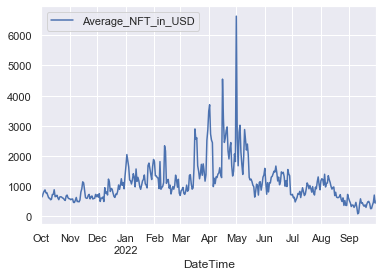

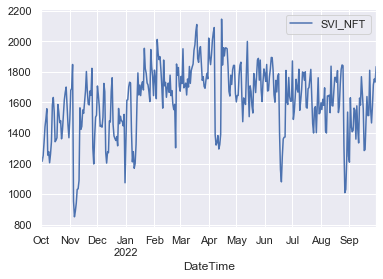

In [156]:
df_reg_all_with_dummies.plot(x='DateTime', y='Average_NFT_in_USD')
df_reg_all_with_dummies.plot(x='DateTime', y='SVI_NFT')

In [54]:
columns_in_use.remove('month')
columns_in_use.remove('Active_market_wallets')

In [55]:
columns_in_use

['Average_NFT_in_USD',
 'Number_of_sales',
 'Sales_USD',
 'Primary_Sales',
 'Secondary_sales',
 'Primary_sales_USD',
 'Secondary_sales_USD',
 'Unique_buyers',
 'Unique_sellers',
 'ΔAverage_NFT_in_USD',
 'ΔActive_market_wallets',
 'ΔNumber_of_sales',
 'ΔSales_USD',
 'ΔPrimary_Sales',
 'ΔSecondary_sales',
 'ΔPrimary_sales_USD',
 'ΔSecondary_sales_USD',
 'ΔUnique_buyers',
 'ΔUnique_sellers',
 'extern_Open_ETH',
 'extern_Open_BTC',
 'extern_Open_NASDAQ',
 'extern_Open_USD',
 'SVI_BAYC',
 'SVI_bored_ape_yacht_club',
 'SVI_cryptopunks',
 'SVI_metaverse',
 'SVI_NFT']

In [56]:
reg_formula = "np.log(Average_NFT_in_USD)~" + '+'.join(columns_in_use)

In [57]:
df_reg_all.corr().style.applymap(color_corr_level)

,Average_NFT_in_USD,Active_market_wallets,Number_of_sales,Sales_USD,Primary_Sales,Secondary_sales,Primary_sales_USD,Secondary_sales_USD,Unique_buyers,Unique_sellers,ΔAverage_NFT_in_USD,ΔActive_market_wallets,ΔNumber_of_sales,ΔSales_USD,ΔPrimary_Sales,ΔSecondary_sales,ΔPrimary_sales_USD,ΔSecondary_sales_USD,ΔUnique_buyers,ΔUnique_sellers,extern_Open_ETH,extern_Open_BTC,extern_Open_NASDAQ,extern_Open_USD,SVI_BAYC,SVI_bored_ape_yacht_club,SVI_cryptopunks,SVI_metaverse,SVI_NFT,month
Average_NFT_in_USD,1,-0.0758781,-0.215075,0.576706,-0.247472,-0.170983,0.418804,0.599188,-0.0953995,-0.0882193,-0.348353,-0.043488,0.0326016,-0.281136,0.0154182,0.0436416,-0.286833,-0.24148,-0.0725128,0.0249701,0.037299,0.0319385,-0.0507861,-0.0924814,0.391387,0.272753,0.122895,0.287036,0.381812,-0.483848
Active_market_wallets,-0.0758781,1,0.929564,0.623948,0.789697,0.975575,0.46194,0.64379,0.994759,0.99026,-0.0185977,-0.112951,-0.107796,-0.0601793,-0.0854946,-0.0952956,-0.0609803,-0.052106,-0.112098,-0.0963481,0.821839,0.826094,0.844409,-0.860896,-0.119642,0.223373,0.158589,-0.0102185,-0.20763,0.0886589
Number_of_sales,-0.215075,0.929564,1,0.543655,0.950024,0.964558,0.454317,0.534633,0.951019,0.903759,-0.0133987,-0.103701,-0.155867,-0.0643928,-0.15842,-0.0883871,-0.0616943,-0.0592849,-0.11655,-0.0771945,0.790354,0.815991,0.802345,-0.771648,-0.191806,0.0897225,0.123765,-0.208758,-0.328584,0.328206
Sales_USD,0.576706,0.623948,0.543655,1,0.498351,0.539715,0.86704,0.967476,0.631317,0.579144,-0.372313,-0.171443,-0.118282,-0.421225,-0.135013,-0.0460694,-0.44213,-0.349529,-0.215202,-0.0568132,0.49076,0.487962,0.617194,-0.689817,0.169019,0.315963,0.147075,0.0785234,0.0294688,-0.187488
Primary_Sales,-0.247472,0.789697,0.950024,0.498351,1,0.833979,0.474543,0.46059,0.834764,0.738788,-0.0320381,-0.0975211,-0.181137,-0.0926688,-0.229413,-0.0383866,-0.0962385,-0.0779183,-0.131827,-0.0405252,0.670773,0.709828,0.67723,-0.624326,-0.193324,0.0133384,0.073692,-0.317055,-0.380693,0.438081
Secondary_sales,-0.170983,0.975575,0.964558,0.539715,0.833979,1,0.401927,0.555686,0.975405,0.972993,0.00339732,-0.100868,-0.122399,-0.0354899,-0.0861047,-0.123784,-0.0277027,-0.0389294,-0.0945836,-0.102193,0.830032,0.842336,0.845816,-0.835905,-0.175622,0.147317,0.156475,-0.101003,-0.259013,0.209837
Primary_sales_USD,0.418804,0.46194,0.454317,0.86704,0.474543,0.401927,1,0.712805,0.491612,0.394609,-0.441611,-0.177628,-0.107029,-0.514699,-0.15972,0.0116263,-0.62066,-0.347254,-0.244875,-0.0111671,0.371166,0.365311,0.648103,-0.652188,0.0779848,0.173774,0.0886044,0.00442587,-0.085563,0.0460631
Secondary_sales_USD,0.599188,0.64379,0.534633,0.967476,0.46059,0.555686,0.712805,1,0.639098,0.614905,-0.299886,-0.151152,-0.112162,-0.33163,-0.108963,-0.0707532,-0.307261,-0.31572,-0.17861,-0.0743047,0.502391,0.501426,0.561142,-0.652069,0.198333,0.356549,0.162051,0.108291,0.0849262,-0.287311
Unique_buyers,-0.0953995,0.994759,0.951019,0.631317,0.834764,0.975405,0.491612,0.639098,1,0.97402,-0.0280825,-0.121355,-0.12629,-0.0771394,-0.115799,-0.0894455,-0.0803729,-0.0646,-0.133677,-0.0881676,0.817127,0.823882,0.839836,-0.846805,-0.131343,0.201671,0.152977,-0.0461656,-0.238068,0.136687
Unique_sellers,-0.0882193,0.99026,0.903759,0.579144,0.738788,0.972993,0.394609,0.614905,0.97402,1,-0.00193724,-0.110522,-0.0984203,-0.0363543,-0.0554431,-0.119116,-0.0306591,-0.0376119,-0.0933977,-0.121157,0.808334,0.816199,0.83364,-0.858367,-0.126137,0.212681,0.161926,-0.00213777,-0.189024,0.0524592


In [58]:
reg_formula

'np.log(Average_NFT_in_USD)~Average_NFT_in_USD+Number_of_sales+Sales_USD+Primary_Sales+Secondary_sales+Primary_sales_USD+Secondary_sales_USD+Unique_buyers+Unique_sellers+ΔAverage_NFT_in_USD+ΔActive_market_wallets+ΔNumber_of_sales+ΔSales_USD+ΔPrimary_Sales+ΔSecondary_sales+ΔPrimary_sales_USD+ΔSecondary_sales_USD+ΔUnique_buyers+ΔUnique_sellers+extern_Open_ETH+extern_Open_BTC+extern_Open_NASDAQ+extern_Open_USD+SVI_BAYC+SVI_bored_ape_yacht_club+SVI_cryptopunks+SVI_metaverse+SVI_NFT'

In [60]:
from patsy import dmatrices
y, X = dmatrices(reg_formula, 
                 data=df_reg_all, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     np.log(Average_NFT_in_USD)   R-squared:                       0.943
Model:                                    OLS   Adj. R-squared:                  0.936
Method:                         Least Squares   F-statistic:                     142.5
Date:                        Sun, 23 Oct 2022   Prob (F-statistic):          3.81e-124
Time:                                11:52:46   Log-Likelihood:                 178.44
No. Observations:                         251   AIC:                            -302.9
Df Residuals:                             224   BIC:                            -207.7
Df Model:                                  26                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [146]:
df_reg_all_with_dummies.to_csv('all_variables.csv')